## 📚 라이브러리 정리

In [1]:
import pandas as pd
import sklearn
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

 ## 📑 데이터 준비 및 결측치 처리

In [2]:
# 데이터 준비
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts

Date
2010-07-29     7.780000
2010-07-30     7.490000
2010-08-02     7.650000
2010-08-03     7.510000
2010-08-04     7.520000
                ...    
2022-07-22    88.099998
2022-07-25    87.540001
2022-07-26    85.250000
2022-07-27    89.820000
2022-07-28    91.669998
Name: Close, Length: 3021, dtype: float64

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

## 🖨 정성적 분석, 시계열 분해 적용

In [4]:
# 로그 변환 시도 
ts_log = np.log(ts)

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

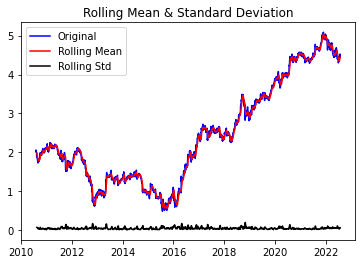

Results of Dickey-Fuller Test:
Test Statistic                    0.074267
p-value                           0.964260
#Lags Used                        3.000000
Number of Observations Used    3017.000000
Critical Value (1%)              -3.432519
Critical Value (5%)              -2.862498
Critical Value (10%)             -2.567280
dtype: float64


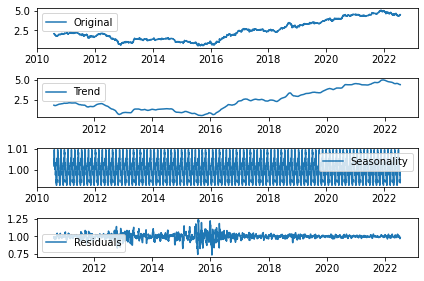

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.413828e+01
p-value                        2.269711e-26
#Lags Used                     2.900000e+01
Number of Observations Used    2.961000e+03
Critical Value (1%)           -3.432560e+00
Critical Value (5%)           -2.862517e+00
Critical Value (10%)          -2.567290e+00
dtype: float64


## 📜 학습,테스트 데이터 분리

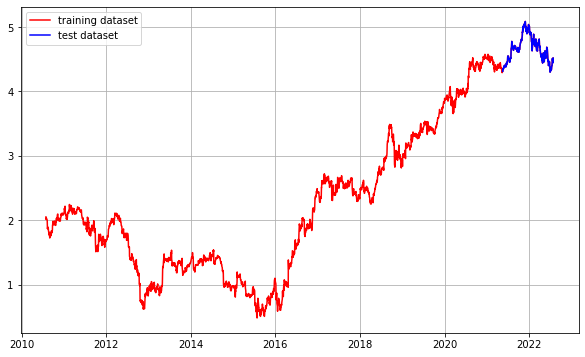

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 📕 p,q,d  ARIMA모수 구하기

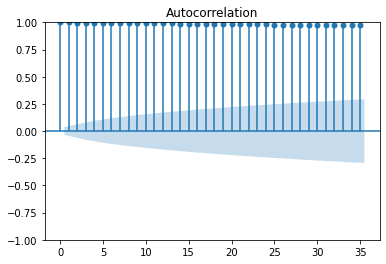

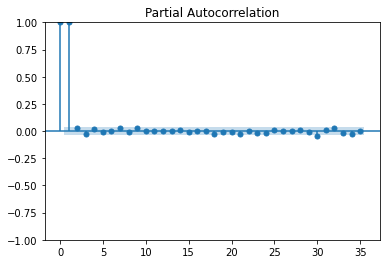

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.879071
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    3017.000000
Critical Value (1%)              -3.432519
Critical Value (5%)              -2.862498
Critical Value (10%)             -2.567280
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.785220e+01
p-value                        3.076341e-30
#Lags Used                     2.700000e+01
Number of Observations Used    2.991000e+03
Critical Value (1%)           -3.432538e+00
Critical Value (5%)           -2.862507e+00
Critical Value (10%)          -2.567285e+00
dtype: float64


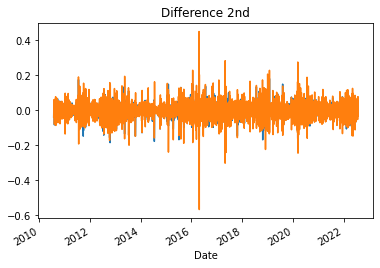

In [11]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 📦 ARIMA 모델링 

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 2, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2718
Model:                 ARIMA(0, 2, 2)   Log Likelihood                5185.262
Date:                Fri, 29 Jul 2022   AIC                         -10364.525
Time:                        11:24:25   BIC                         -10346.804
Sample:                             0   HQIC                        -10358.119
                               - 2718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0228      0.013    -79.196      0.000      -1.048      -0.998
ma.L2          0.0244      0.013      1.882      0.060      -0.001       0.050
sigma2         0.0013   1.37e-05     93.934      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


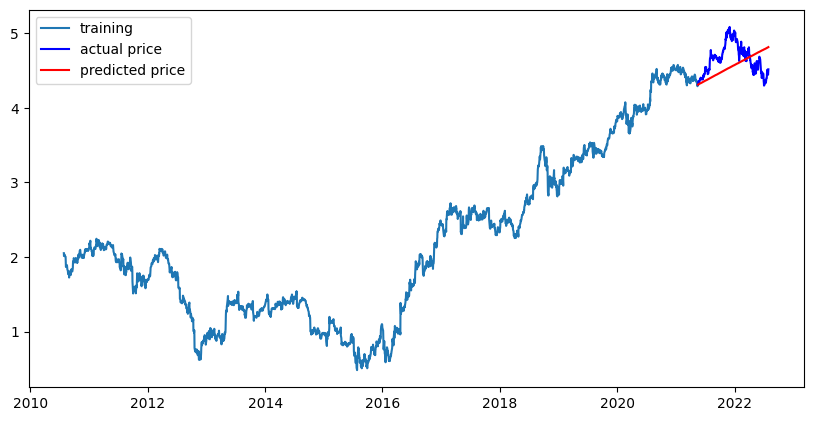

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


## 📗 검증

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  806.5121039245197
MAE:  23.518238956387474
RMSE:  28.399156746715555
MAPE: 21.31%
